In [112]:
import data_structure as ds
from data_structure import Gender
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.power as smp
import scipy.stats as stats
import pandas as pd
import seaborn as sns

In [113]:
df = ds.search_all()
df['gender_str'] = df['gender'].apply(lambda x: x.name)

In [114]:
m_mask = df['gender'] == Gender.Male
f_mask = df['gender'] == Gender.Female

df_male, df_female = df[m_mask], df[f_mask]

In [115]:
deserved_group_df = pd.concat(
                    [df_male.value_counts('deserved_salary').sort_index(),
                      df_female.value_counts('deserved_salary').sort_index()],
                        axis=1).reset_index()
deserved_group_df.replace(np.nan, 0, inplace=True)
deserved_group_df = deserved_group_df.apply(lambda x: x.astype(int), axis=1)
deserved_group_df.columns = ['salary',	'male', 'female']

current_group_df = pd.concat(
                    [df_male.value_counts('current_salary').sort_index(),
                     df_female.value_counts('current_salary').sort_index()],
                        axis=1).reset_index()
current_group_df.replace(np.nan, 0, inplace=True)
current_group_df = current_group_df.apply(lambda x: x.astype(int), axis=1)
current_group_df.columns = ['salary',	'male', 'female']

display(deserved_group_df)
display(current_group_df)

,salary,male,female
0,95,15,20
1,100,18,34
2,105,14,16
3,110,50,23
4,115,6,2
5,120,2,0


,salary,male,female
0,85,76,89
1,90,1,0
2,92,1,0
3,95,27,4
4,80,0,2


In [116]:
observed_deserved = deserved_group_df[['male', 'female']].to_numpy()

observed_current = current_group_df[['male', 'female']].to_numpy()

chi2_stat_deserved, p_val_deserved, dof_deserved, expected_deserved = stats.chi2_contingency(observed_deserved)
print(f"Deserved Salary Chi-square Test:\nChi2 Stat: {chi2_stat_deserved}, P-value: {p_val_deserved}, Degrees of Freedom: {dof_deserved}")

chi2_stat_current, p_val_current, dof_current, expected_current = stats.chi2_contingency(observed_current)
print(f"Current Salary Chi-square Test:\nChi2 Stat: {chi2_stat_current}, P-value: {p_val_current}, Degrees of Freedom: {dof_current}")

Deserved Salary Chi-square Test:
Chi2 Stat: 19.305260491788452, P-value: 0.0016860052118483518, Degrees of Freedom: 5
Current Salary Chi-square Test:
Chi2 Stat: 21.642865717568608, P-value: 0.00023603779182530522, Degrees of Freedom: 4


In [117]:
# Calculating the residuals
residuals = (observed_deserved - expected_deserved) / np.sqrt(expected_deserved)
print("Residuals:\n", residuals)

Residuals:
 [[-0.78733599  0.82773811]
 [-1.77992468  1.87126146]
 [-0.44095855  0.46358632]
 [ 1.88588761 -1.98266187]
 [ 0.87831007 -0.92338052]
 [ 0.92710507 -0.97467943]]


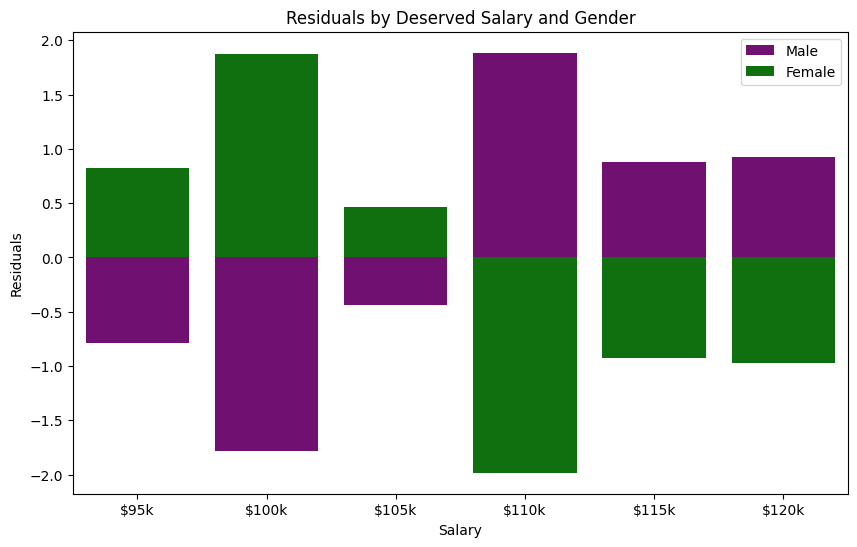

In [137]:
import seaborn as sns

ticks = [
    f'${salary}k' for salary in
    deserved_group_df['salary'].to_numpy()
    ]
male_residuals = residuals[:, 0]
female_residuals = residuals[:, 1]
plt.figure(figsize=(10, 6))
sns.barplot(x=ticks, y=male_residuals, color='purple', label='Male')
sns.barplot(x=ticks, y=female_residuals, color='green', label='Female')
plt.xlabel('Salary')
plt.ylabel('Residuals')
plt.title('Residuals by Deserved Salary and Gender')
plt.legend()
plt.show()

In [119]:
total_men = deserved_group_df['male'].sum()
total_women = deserved_group_df['female'].sum()
proportions_men = [count / total_men for count in deserved_group_df['male']]
proportions_women = [count / total_women for count in deserved_group_df['female']]

print("Proportions of Men in Each Salary Category:", proportions_men)
print("Proportions of Women in Each Salary Category:", proportions_women)

Proportions of Men in Each Salary Category: [np.float64(0.14285714285714285), np.float64(0.17142857142857143), np.float64(0.13333333333333333), np.float64(0.47619047619047616), np.float64(0.05714285714285714), np.float64(0.01904761904761905)]
Proportions of Women in Each Salary Category: [np.float64(0.21052631578947367), np.float64(0.35789473684210527), np.float64(0.16842105263157894), np.float64(0.24210526315789474), np.float64(0.021052631578947368), np.float64(0.0)]


In [120]:
deserved_group_df

,salary,male,female
0,95,15,20
1,100,18,34
2,105,14,16
3,110,50,23
4,115,6,2
5,120,2,0


In [121]:
from statsmodels.stats.proportion import proportions_ztest

nobs = np.array([total_men, total_women])
for count, (index, row) in zip(observed_deserved, deserved_group_df.iterrows()):
    stat, pval = proportions_ztest(count, nobs)
    print(f"\nSalary: {row['salary']}, Z-statistic: {stat}, P-value: {pval}")


Salary: 95, Z-statistic: -1.2577268264001904, P-value: 0.2084905669540421

Salary: 100, Z-statistic: -3.0021954357153477, P-value: 0.0026804003454815695

Salary: 105, Z-statistic: -0.6939712870363024, P-value: 0.4877002157180125

Salary: 110, Z-statistic: 3.4338564831558394, P-value: 0.0005950591683321875

Salary: 115, Z-statistic: 1.30066495428618, P-value: 0.19337316310500363

Salary: 120, Z-statistic: 1.3519622138957241, P-value: 0.1763874034088727


In [122]:
from statsmodels.stats.power import zt_ind_solve_power
# Parameters
alpha = 0.05   # Significance level
power = 0.80   # Power of the test

for count, (index, row) in zip(observed_deserved, deserved_group_df.iterrows()):
    p1 = count[0]/total_men
    p2 = count[1]/total_women

    effect_size = abs(p1 - p2)

    # Calculate sample size per group
    sample_size = zt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')
    print(f"Required sample size for salary group {row['salary']}: {sample_size}")

Required sample size for salary group 95: 3428.110951838808
Required sample size for salary group 100: 451.47793167742066
Required sample size for salary group 105: 12750.473898260503
Required sample size for salary group 110: 286.47626460985924
Required sample size for salary group 115: 12051.952565055728
Required sample size for salary group 120: 43266.84355717066


In [123]:
df.to_csv('salary_data.csv', index=False)